### Model:

* $I$ species observed at $J$ locations over time.

* $Y_{tij} = 1$ if species $j$ (for $j=1,\dots,J$) is observed at location $i$ (for $i=1,\dots,I$) at time $t$, and zero otherwise.

* Assume latent factors $X_t \in \mathbb{R}^{I \times K}$; $X_t= X_{tik}$, $i=1,\dots,I$, $k=1,\dots,K$.

* $X_{ti} \in \mathbb{R}^K$ are $K$ latent factors at location $i$. Model assumes that there are some latent factors such as food, water, sunlight etc.

* Logit model:
\begin{equation}
\mathrm{P}(Y_{tij} = 1) = \frac{1}{1+\exp\{-(\alpha + \lambda^\top_j X_{ti})\}},
\quad 
i = 1, \dots, I, ~ j = 1, \dots, J,
\end{equation}
where $\lambda_j \in \mathbb{R}^K$ for $j=1,\dots,J$ are the effects of the latent factors on species $j$ (for example, how much food does a species need, how much water do they need, etc).

* Assume basic auto-regressive model for $X_t$:
\begin{equation*}
X_t = c + \phi X_{t-1} + \varepsilon_t, \quad \varepsilon_t \stackrel{\text{i.i.d.}}{\sim} \mathcal{N}(0,\sigma^2).
\end{equation*}


In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, math, pandas, numpy.random as npr, pystan as ps
from pylab import plot, show, legend
from time import time
from scipy.stats import *
from tqdm import trange
from ecology_functions import *

In [2]:
sm_unknownX = ps.StanModel(file="ecology_unknownX.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_171735472178a49b36301a4b140135b4 NOW.


In [3]:
T = 100
I = 5  # number of locations
J = 3 # number of species
K = 2  # number of latent factors

In [4]:
lmbda = npr.randn(J,K)
alpha = npr.randn(J)
c = 0
phi = 0.5
logsigmasq = 0
x_0 = npr.randn(I,K)

theta = [alpha, lmbda, c, phi, logsigmasq]
Y, X = simulate_data(x_0, T, J, theta)

In [5]:
data = dict(T=T, I=I, J=J, K=K, y=Y, x_0=x_0, pr_sigma=1)

In [6]:
n_chains = 10
start = time()
fit_unknownX = sm_unknownX.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=1000)
print(round((time()-start)/60,2), "minutes to run")
trace = fit_unknownX.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


1.26 minutes to run


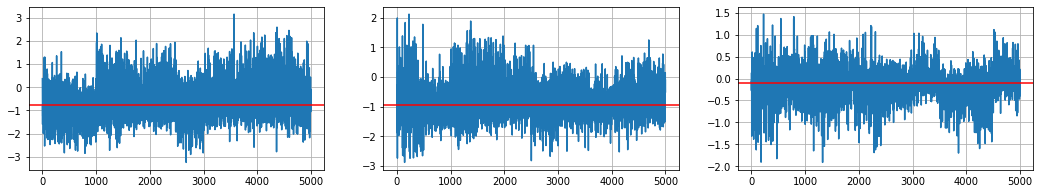

In [7]:
plt.figure(figsize=(18,3))
for j in range(J) :
    plt.subplot(1,J,j+1)
    plt.plot(trace['alpha'][:,j])
    plt.axhline(y=alpha[j], color="red")
    plt.grid(True)

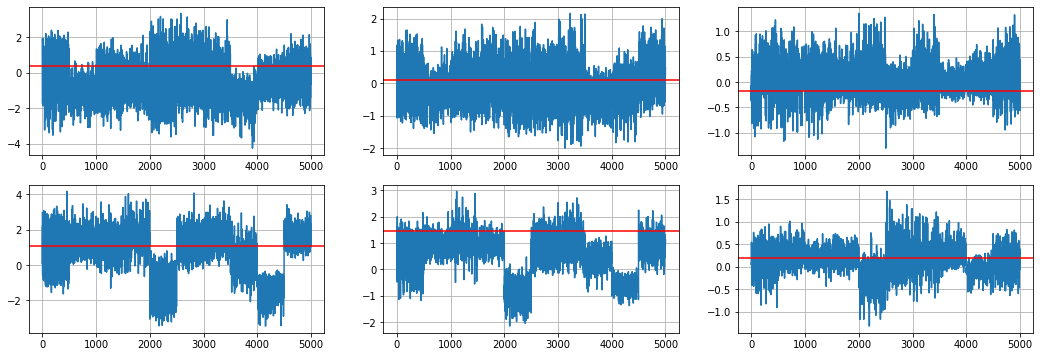

In [8]:
plt.rcParams['figure.figsize'] = (18, 6)
for k in range(K) :
    for j in range(J) :
        idx = k*J + j + 1
        plt.subplot(K,J,idx)
        plt.plot(trace['lambda'][:,j,k])
        plt.grid(True)
        plt.axhline(y=lmbda[j,k], color="red")
plt.show()

In [9]:
n_mcmc = np.shape(trace['X'])[0]

In [10]:
reg_coeff = np.zeros((n_mcmc,T,J,I))
for i in trange(n_mcmc) :
    for t in range(T) :
        for j in range(J) : 
            reg_coeff[i,t,j,:] = trace['alpha'][i,j] + trace['lambda'][i,j].dot(trace['X'][i,t].transpose())

100%|██████████| 5000/5000 [00:05<00:00, 873.48it/s]


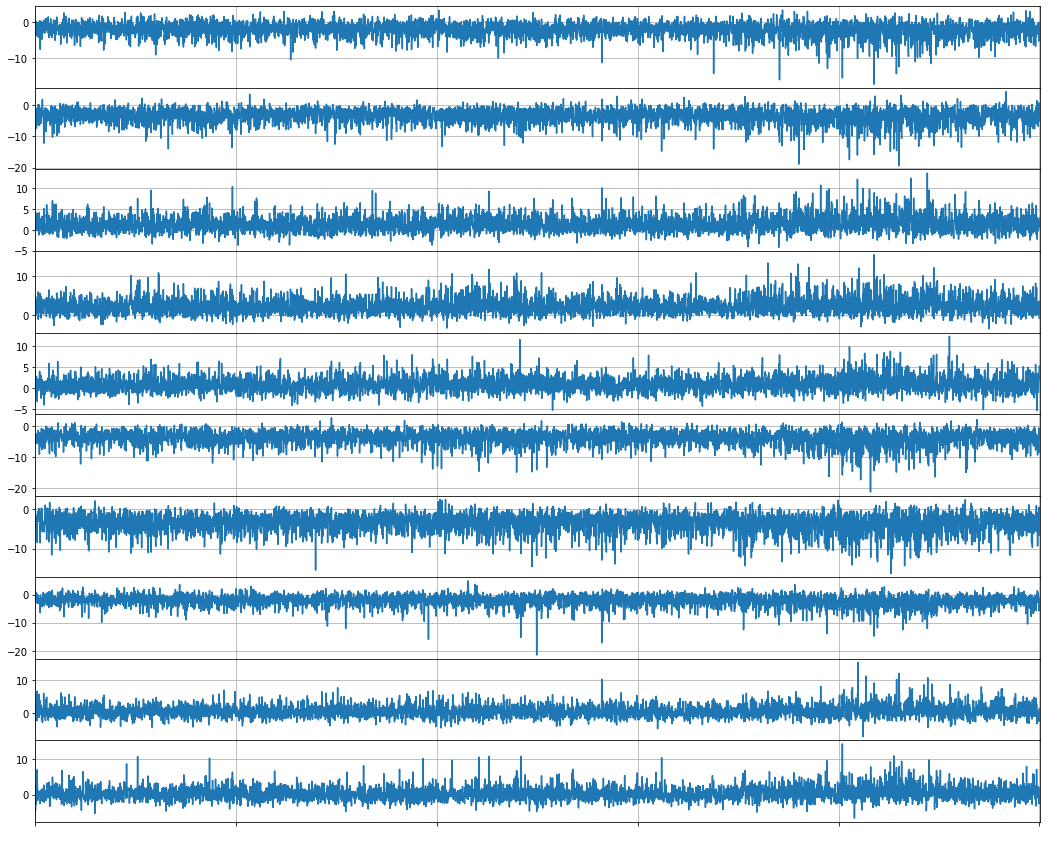

In [12]:
plt.rcParams['figure.figsize'] = (18, 15)
j = npr.choice(J)
i = npr.choice(I)
for (idx,t) in enumerate(npr.choice(T,10)) :
    plt.subplot(10,1,idx+1)
    plt.plot(reg_coeff[:,t,j,i])
    plt.xlim(0,n_mcmc+1)
    plt.grid(True)
    plt.xticks(alpha=0)
    plt.subplots_adjust(hspace=0)